## This script loops through subfolders in 'cpics_img' to calculate deployment times for each CTD cast as sampling events in 'ctd_meta_v4.csv'.

## Sometimes there are subfolders in 'cpics_img' that don't match any sampling event. These will be skipped.

## Written by E. Montes (enrique.montes@noaa.gov)
## November 3rd 2025




**Workflow:**

1.  **Load Metadata:** Read the event metadata CSV.
2.  **Scan All Images:** Scan `cpics_img` and find *all* image timestamps, storing them in one large, sorted list.
3.  **Process Events with Gap Detection:**
      * For each event, define a large "search window" (from 10 min before the event to 20 min before the *next* event).
      * Find all images in this window.
      * Calculate the time differences *between* these images.
      * Find the *first gap* larger than a threshold (e.g., 30 minutes).
      * The deployment is the block of images *before* this first gap.
4.  **Save Results:** Add the calculated durations to the metadata.

In [1]:
# Cell 1: Imports
import os
import pandas as pd
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings('ignore')

### 1. Load Event Metadata

First, we load the `ctd_meta_v4.csv` file, which contains the timestamp for each CTD cast. We'll parse the date and time columns into a single `datetime` object for easy comparison.

In [2]:
# --- Load the CSV file ---
csv_path = ('/home/enrique.montes@CNS.local/plankton_imaging/ctd_meta_v4.csv')

try:
    data = pd.read_csv(csv_path)
    print(f"Successfully loaded {csv_path}")
except FileNotFoundError:
    print(f"Error: Could not find the CSV file at {csv_path}")
    data = pd.DataFrame() # Create empty dataframe
    
# --- Combine date and time components to create datetime object ---
if not data.empty:
    
    # --- FIX: Drop rows with missing date/time components first ---
    original_rows = len(data)
    data = data.dropna(subset=['year', 'month', 'day', 'time_gmt'])
    new_rows = len(data)
    if original_rows > new_rows:
        print(f"Dropped {original_rows - new_rows} rows with missing date/time data.")
    
    # --- Cast to int (which is now safe) and then to str ---
    dateTimeStr = (data['year'].astype(int).astype(str) + '-' +
                   data['month'].astype(int).astype(str) + '-' +
                   data['day'].astype(int).astype(str) + ' ' +
                   data['time_gmt'])

    # Let pandas automatically infer the format.
    data['timeStamp'] = pd.to_datetime(dateTimeStr) 

    print("Data loaded and timestamps parsed:")
    print(data[['year', 'month', 'day', 'time_gmt', 'timeStamp']].head())

Successfully loaded /home/enrique.montes@CNS.local/plankton_imaging/ctd_meta_v4.csv
Data loaded and timestamps parsed:
   year  month  day    time_gmt           timeStamp
0  2022     12    4  1:01:00 AM 2022-12-04 01:01:00
1  2022     12    4  2:27:00 AM 2022-12-04 02:27:00
2  2022     12    4  3:23:00 AM 2022-12-04 03:23:00
3  2022     12    4  4:45:00 AM 2022-12-04 04:45:00
4  2022     12    4  6:35:00 AM 2022-12-04 06:35:00


### Cell 3: Scan ALL Image Files

Create one single, sorted list of all timestamps from all images.

In [3]:
# Cell 3: Scan All Image Files
parentDir = 'cpics_img' 

# This list will hold all valid timestamps from all matching files
all_file_timestamps = []

print(f"Scanning all images in: {parentDir}")

for root, dirs, files in os.walk(parentDir):
    # Filter out hidden directories
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    
    for file in files:
        if file.startswith('20') and file.endswith('.png'):
            try:
                dateStr = file[0:15] # e.g., '20221204_010047'
                file_timestamp = datetime.strptime(dateStr, '%Y%m%d_%H%M%S')
                all_file_timestamps.append(file_timestamp)
            except ValueError:
                print(f"Skipping file with unexpected name format: {file}")

# --- Convert to a sorted pandas Series for very fast processing ---
if not all_file_timestamps:
    print("Warning: No image files were found.")
    all_timestamps_series = pd.Series(dtype='datetime64[ns]')
else:
    all_timestamps_series = pd.Series(all_file_timestamps).sort_values().reset_index(drop=True)
    print(f"Found and processed {len(all_timestamps_series)} total image files.")
    print("\nFirst 5 image timestamps found:")
    print(all_timestamps_series.head())
    print("\nLast 5 image timestamps found:")
    print(all_timestamps_series.tail())

Scanning all images in: cpics_img
Found and processed 371141 total image files.

First 5 image timestamps found:
0   2022-12-04 01:00:47
1   2022-12-04 01:00:47
2   2022-12-04 01:00:48
3   2022-12-04 01:00:48
4   2022-12-04 01:00:48
dtype: datetime64[ns]

Last 5 image timestamps found:
371136   2025-08-16 15:31:12
371137   2025-08-16 15:31:23
371138   2025-08-16 15:31:25
371139   2025-08-16 15:31:38
371140   2025-08-16 15:31:41
dtype: datetime64[ns]


### Analyze Gap Distribution

This cell plots a histogram of the time gaps between consecutive images.
Look at the plot to find the natural break between "intra-deployment" gaps (left) and "inter-deployment" gaps (right).
The empty space between them is your threshold.

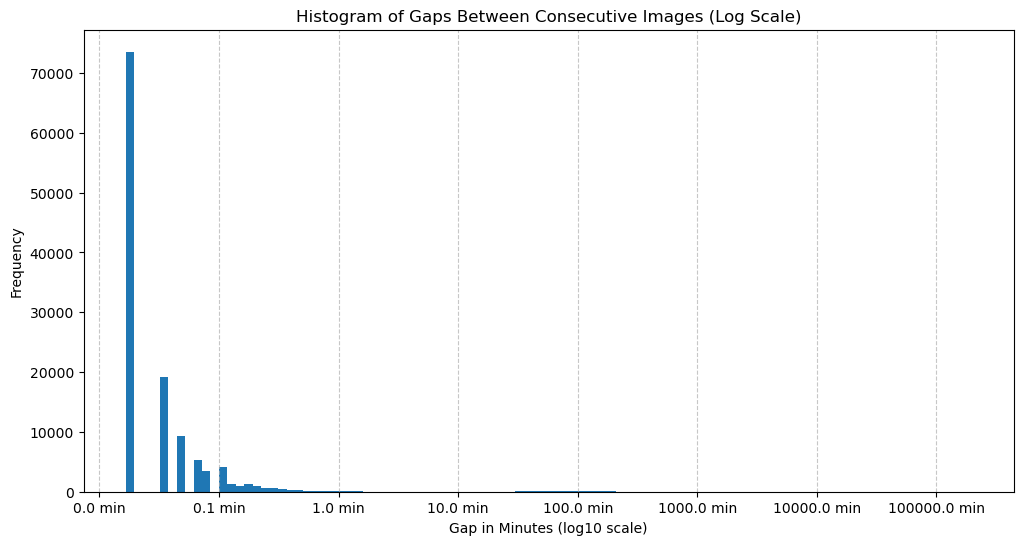


--- How to read this chart: ---
You are likely seeing two distinct 'humps'.
1. A large hump on the left (e.g., 0-1 min): Gaps WITHIN a deployment.
2. A smaller hump on the right (e.g., 20+ min): Gaps BETWEEN deployments.

Look at the empty space between these two humps.
Pick a value (in minutes) from this empty space for the threshold in the next cell.
For example, if the first hump ends at 10 minutes and the next starts at 30, a good threshold is 20.


In [4]:
# Analyze Gap Distribution

if not all_timestamps_series.empty:
    # 1. Calculate all gaps
    gaps_in_seconds = all_timestamps_series.diff().dt.total_seconds()
    gaps_in_minutes = gaps_in_seconds / 60.0

    # 2. Plot a histogram of the log of the gaps (to see both small and large gaps)
    # We filter out gaps <= 0 (e.g., first entry)
    plt.figure(figsize=(12, 6))
    plt.hist(gaps_in_minutes[gaps_in_minutes > 0].apply('log10'), bins=100)
    plt.title('Histogram of Gaps Between Consecutive Images (Log Scale)')
    plt.xlabel('Gap in Minutes (log10 scale)')
    plt.ylabel('Frequency')
    
    # Add labels for interpretation
    # (e.g., 1 min = 0, 10 min = 1, 60 min = 1.78, 100 min = 2)
    plt.gca().set_xticklabels([f"{10**x:.1f} min" for x in plt.gca().get_xticks()])
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    print("\n--- How to read this chart: ---")
    print("You are likely seeing two distinct 'humps'.")
    print("1. A large hump on the left (e.g., 0-1 min): Gaps WITHIN a deployment.")
    print("2. A smaller hump on the right (e.g., 20+ min): Gaps BETWEEN deployments.")
    print("\nLook at the empty space between these two humps.")
    print("Pick a value (in minutes) from this empty space for the threshold in the next cell.")
    print("For example, if the first hump ends at 10 minutes and the next starts at 30, a good threshold is 20.")
else:
    print("No timestamps found, skipping gap analysis.")

### Find Gaps and Identify Deployments

**ACTION REQUIRED:** Look at the chart above and choose a threshold (in minutes) that separates the two gap clusters.
Set the `GAP_THRESHOLD_MINUTES = XX` with your selected value. Using 10 minutes looks appropriate

In [5]:
# Find Gaps and Identify Deployments. This is the time between the last timestamp of one deployment and the first timestamp of the next.

# --- !!! ACTION REQUIRED !!! ---
# Based on the histogram in Cell 4, update this value.
# For example, if the gap is at 10 minutes, set this to 10.
GAP_THRESHOLD_MINUTES = 10 # <--- CHANGE THIS VALUE
GAP_THRESHOLD = pd.Timedelta(minutes=GAP_THRESHOLD_MINUTES)
# -----------------------------

print(f"Identifying deployments using a gap threshold of {GAP_THRESHOLD_MINUTES} minutes...")

# 1. Create a DataFrame of all images
image_deployments = pd.DataFrame({'timestamp': all_timestamps_series})

# 2. Calculate the time gap between each consecutive image
gaps = image_deployments['timestamp'].diff()

# 3. Find where the gap is larger than our threshold
is_new_deployment = (gaps > GAP_THRESHOLD)

# 4. Create a "deployment_id"
image_deployments['deployment_id'] = is_new_deployment.cumsum()

# 5. Get the start and end time for each deployment
deployment_stats = image_deployments.groupby('deployment_id')['timestamp'].agg(
    start_time='min',
    end_time='max'
)

# 6. Calculate the duration of each deployment
deployment_stats['duration_sec'] = (deployment_stats['end_time'] - deployment_stats['start_time']).dt.total_seconds()
deployment_stats['deployDurMin'] = deployment_stats['duration_sec'] / 60.0

print(f"Identified {len(deployment_stats)} distinct deployments.")
print("\nDeployment stats (first 10):")
print(deployment_stats.head(10))

Identifying deployments using a gap threshold of 10 minutes...
Identified 1078 distinct deployments.

Deployment stats (first 10):
                       start_time            end_time  duration_sec  \
deployment_id                                                         
0             2022-12-04 01:00:47 2022-12-04 01:06:38         351.0   
1             2022-12-04 02:27:58 2022-12-04 02:31:02         184.0   
2             2022-12-04 03:26:54 2022-12-04 03:26:55           1.0   
3             2022-12-04 04:43:00 2022-12-04 04:47:54         294.0   
4             2022-12-04 06:35:34 2022-12-04 06:41:56         382.0   
5             2022-12-04 08:17:08 2022-12-04 08:22:55         347.0   
6             2022-12-04 09:32:09 2022-12-04 09:37:39         330.0   
7             2022-12-04 10:40:00 2022-12-04 10:43:46         226.0   
8             2022-12-04 11:20:29 2022-12-04 11:24:21         232.0   
9             2022-12-04 11:50:03 2022-12-04 11:53:53         230.0   

               d

### Match Events to Deployments and Get Durations

This cell matches each CTD event to the deployment block it falls into.
If you've chosen the correct threshold, you should now see a 1-to-1 mapping
between events and deployments (i.e., no repeated `deployDurMin` values).

In [6]:
# Match Events to Deployments
# (This cell is unchanged, but its output will be correct now)

print("\n--- Matching CTD Events to Deployments ---")

# 1. Ensure both DataFrames are sorted by time for the merge
data_sorted = data.sort_values('timeStamp')
image_deployments_sorted = image_deployments.sort_values('timestamp')

# 2. Perform the 'as-of' merge.
# We set a tolerance so an event (CTD cast) can only match an image
# that occurred recently. This prevents a CTD cast at 14:00 from
# matching a deployment that ended at 12:00.
# We'll use a 20-minute tolerance (the 10-min before, 10-min after logic)
merge_tolerance = pd.Timedelta(minutes=20)

merged_data = pd.merge_asof(
    data_sorted,
    image_deployments_sorted,
    left_on='timeStamp',
    right_on='timestamp',
    direction='nearest', # Find the *closest* image to the CTD cast
    tolerance=merge_tolerance
)

# 3. Join the duration stats
#    Now we merge in the duration for the deployment_id we found.
final_data = pd.merge(
    merged_data,
    deployment_stats[['deployDurMin']],
    on='deployment_id',
    how='left'
)

# 4. Sort back to the original index order
final_data = final_data.sort_index()

print("--- Matching Complete ---")


--- Matching CTD Events to Deployments ---
--- Matching Complete ---


### Cell 7: Review Final Results

Review the final data. If you still see repeated `deployDurMin` values,
go back to **Cell 5** and try a *smaller* `GAP_THRESHOLD_MINUTES`.

In [7]:
# Cell 7: Review Final Results
# (I've added sorting to make groups easier to see)

print("DataFrame with final calculated deployment durations:")

# Sort by deployment_id to make groups easy to see
final_data_sorted_for_review = final_data.sort_values(by=['deployment_id', 'timeStamp'])

# Print the relevant columns
print(final_data_sorted_for_review[[
    'timeStamp', 
    'deployment_id', 
    'deployDurMin',
    'year', 
    'month', 
    'day', 
    'time_gmt'
]].head(20)) # Print the first 20 rows

# --- Optional: Save the updated DataFrame to a new CSV file ---
output_filename = 'ctd_meta_with_durations.csv'
final_data.to_csv(output_filename, index=False)
print(f"\nSuccessfully saved updated data to {output_filename}")

DataFrame with final calculated deployment durations:
             timeStamp  deployment_id  deployDurMin  year  month  day  \
0  2022-12-04 01:01:00            0.0      5.850000  2022     12    4   
1  2022-12-04 02:27:00            1.0      3.066667  2022     12    4   
2  2022-12-04 03:23:00            2.0      0.016667  2022     12    4   
3  2022-12-04 04:45:00            3.0      4.900000  2022     12    4   
4  2022-12-04 06:35:00            4.0      6.366667  2022     12    4   
5  2022-12-04 08:17:00            5.0      5.783333  2022     12    4   
6  2022-12-04 09:33:00            6.0      5.500000  2022     12    4   
7  2022-12-04 10:41:00            7.0      3.766667  2022     12    4   
8  2022-12-04 11:21:00            8.0      3.866667  2022     12    4   
9  2022-12-04 11:51:00            9.0      3.833333  2022     12    4   
10 2022-12-04 12:11:00            9.0      3.833333  2022     12    4   
18 2022-12-04 22:24:00           10.0      6.750000  2022     12    4 

## --- Check sampling time distribution ---

--- Analyzing Deployment Duration Distribution ---
Descriptive Statistics for Deployment Durations (in minutes):
count    1078.000000
mean        5.336271
std         3.258524
min         0.000000
25%         4.033333
50%         5.100000
75%         6.366667
max        47.533333
Name: deployDurMin, dtype: float64


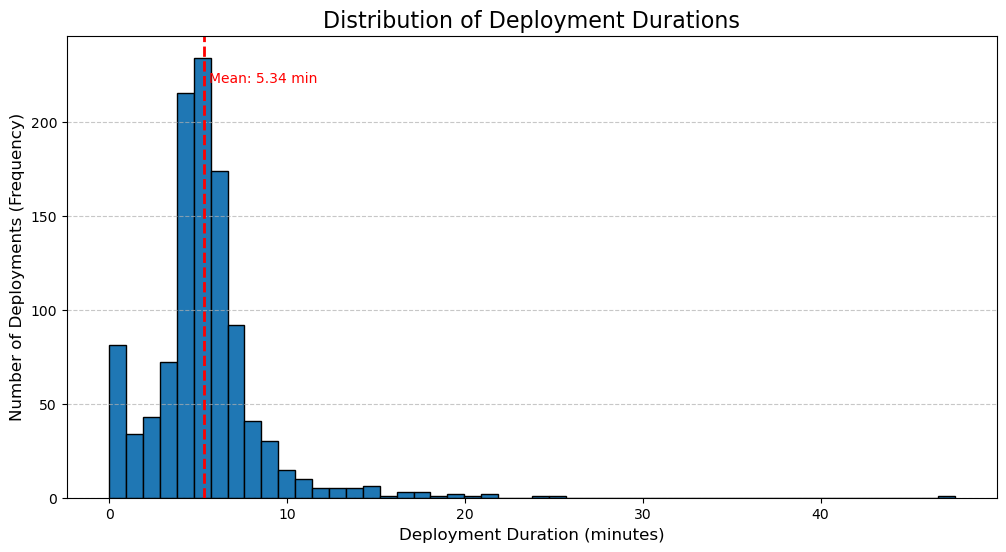


--- Interpretation ---
Look for bars far to the right of the main cluster.
These represent your 'very long' deployments (the outliers).
The 'max' value in the statistics above is your longest deployment.


--- Identifying Sampling Events with Deployment Times >= 20 Minutes ---
Found 10 sampling events with deployment times >= 20 Minutes:
               timeStamp Station  deployment_id  deployDurMin  year  month  \
1481 2025-08-13 08:11:00    BG17         1040.0     47.533333  2025      8   
1480 2025-08-13 07:38:00    BG17         1040.0     47.533333  2025      8   
1471 2025-08-12 22:58:00    BG11         1034.0     24.933333  2025      8   
1472 2025-08-12 23:17:00    BG11         1034.0     24.933333  2025      8   
1468 2025-08-12 20:13:00     BG9         1032.0     24.083333  2025      8   
1469 2025-08-12 20:30:00     BG9         1032.0     24.083333  2025      8   
329  2023-05-22 19:29:00     9.5          246.0     21.650000  2023      5   
97   2023-01-13 07:35:00     TB2   

In [12]:
# Analyze Distribution of Deployment Durations

print("--- Analyzing Deployment Duration Distribution ---")

# We use the 'deployment_stats' DataFrame, which has one row per unique deployment.
if 'deployment_stats' in locals() and not deployment_stats.empty:
    
    # --- 1. Print Descriptive Statistics ---
    # This will immediately show you the min, max, and average durations.
    print("Descriptive Statistics for Deployment Durations (in minutes):")
    print(deployment_stats['deployDurMin'].describe())
    
    # --- 2. Plot a Histogram ---
    plt.figure(figsize=(12, 6))
    # 'bins=50' is a good starting point; you can adjust this.
    plt.hist(deployment_stats['deployDurMin'], bins=50, edgecolor='black')
    
    plt.title('Distribution of Deployment Durations', fontsize=16)
    plt.xlabel('Deployment Duration (minutes)', fontsize=12)
    plt.ylabel('Number of Deployments (Frequency)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add a vertical line for the mean to see the skew
    mean_duration = deployment_stats['deployDurMin'].mean()
    plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=2)
    plt.text(mean_duration * 1.05, plt.ylim()[1] * 0.9, f'Mean: {mean_duration:.2f} min', color='red')
    
    plt.show()

    print("\n--- Interpretation ---")
    print("Look for bars far to the right of the main cluster.")
    print("These represent your 'very long' deployments (the outliers).")
    print("The 'max' value in the statistics above is your longest deployment.")
    
else:
    print("Error: The 'deployment_stats' DataFrame was not found.")
    print("Please make sure you have successfully run 'Cell 5' (the 'Find Gaps and Identify Deployments' cell).")

# --- List Sampling Events with Long Deployments ---

deploy_time = 20  # minutes
print(f"\n\n--- Identifying Sampling Events with Deployment Times >= {deploy_time} Minutes ---")

# We check for 'final_data', which links events to deployment stats
if 'final_data' in locals() and not final_data.empty:
    
    # 1. Filter the 'final_data' DataFrame
    long_deployments = final_data[final_data['deployDurMin'] >= deploy_time].copy()
    
    if long_deployments.empty:
        print(f"No sampling events found with deployment times >= {deploy_time} Minutes.")
    else:
        print(f"Found {len(long_deployments)} sampling events with deployment times >= {deploy_time} Minutes:")
        
        # 2. Sort by duration (longest first) for easier review
        long_deployments_sorted = long_deployments.sort_values(by='deployDurMin', ascending=False)
        
        # 3. Display the relevant info for these events
        print(long_deployments_sorted[[
            'timeStamp', 
            'Station',
            'deployment_id', 
            'deployDurMin',
            'year', 
            'month', 
            'day', 
            'time_gmt'
        ]])
        
else:
    print("Error: The 'final_data' DataFrame was not found.")
    print("Please make sure you have successfully run 'Cell 6' (the 'Match Events to Deployments' cell).")    

### --- Cell for Testing: Calculate Duration for a Single Folder ---

In [ ]:
# --- Cell for Testing: Find Deployments Within a Single Folder ---

# --- 1. Configuration ---
# Set the exact path to the hourly folder you want to test
TEST_FOLDER_PATH = 'cpics_img/20241110/20241110_0400' # <--- CHANGE THIS PATH

# Set the gap threshold as requested
GAP_THRESHOLD_MINUTES = 10
GAP_THRESHOLD = pd.Timedelta(minutes=GAP_THRESHOLD_MINUTES)
# -------------------------------------

print(f"--- Testing Folder: {TEST_FOLDER_PATH} ---")
print(f"--- Using Gap Threshold: {GAP_THRESHOLD_MINUTES} minutes ---")

timestamps_in_folder = []
duration_min = 0.0

if not os.path.isdir(TEST_FOLDER_PATH):
    print(f"Error: Directory not found at '{TEST_FOLDER_PATH}'. Please check the path.")
else:
    # Get all timestamps from the specified folder
    for file in os.listdir(TEST_FOLDER_PATH):
        if file.startswith('20') and file.endswith('.png'):
            try:
                dateStr = file[0:15]
                file_timestamp = datetime.strptime(dateStr, '%Y%m%d_%H%M%S')
                timestamps_in_folder.append(file_timestamp)
            except ValueError:
                print(f"Skipping file with unexpected name format: {file}")

    if not timestamps_in_folder:
        print("No valid .png files found in this folder.")
    else:
        print(f"Found {len(timestamps_in_folder)} total images in folder.")
        
        # --- 2. Perform Gap Detection Logic ---
        
        # Create a DataFrame from the sorted list of timestamps
        df = pd.DataFrame({'timestamp': sorted(timestamps_in_folder)})

        # Calculate the time gap between each consecutive image
        gaps = df['timestamp'].diff()

        # Find where the gap is larger than our threshold
        is_new_deployment = (gaps > GAP_THRESHOLD)

        # Create a "deployment_id" for each block
        df['deployment_id'] = is_new_deployment.cumsum()

        # --- 3. Group by Deployment ID and Calculate Stats ---
        deployment_stats = df.groupby('deployment_id')['timestamp'].agg(
            start_time='min',
            end_time='max',
            image_count='count'
        )

        # Calculate the duration (in minutes) for each deployment
        deployment_stats['duration_sec'] = (deployment_stats['end_time'] - deployment_stats['start_time']).dt.total_seconds()
        deployment_stats['duration_min'] = deployment_stats['duration_sec'] / 60.0

        # --- 4. Report the Results ---
        num_deployments = len(deployment_stats)
        print(f"\nFound {num_deployments} distinct deployment(s) in this folder:")
        
        # Re-order columns for a nice printout
        final_stats = deployment_stats[['start_time', 'end_time', 'duration_min', 'image_count']]
        print(final_stats)

print("\n--- Test Complete ---")

## NOTES:

### Deployment time for BG18 during WS24205 on 2024-07-26 at 20:18 was set manually to 40.55 min because the corresponding folder in 'cpics_img' contains pngs that appear to come from separate deployments because of the long cast. 

